In [71]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dpipe.io import load

In [19]:
path_base_new = Path('/gpfs/data/gpfs0/b.shirokikh/experiments/da/miccai2021_spottune/baseline/cc359_unet2d_one2all/')
path_oracle_new = Path('/gpfs/data/gpfs0/b.shirokikh/experiments/da/miccai2021_spottune/baseline/cc359_unet2d_oracle/')

path_base_old = Path('/gpfs/data/gpfs0/b.shirokikh/experiments/da/dart_base/cc359_unet2d_one2all/')
path_oracle_old = Path('/gpfs/data/gpfs0/b.shirokikh/experiments/da/dart_base/cc359_unet2d_oracle/')

meta = pd.read_csv('/gpfs/data/gpfs0/b.shirokikh/data/cc359/meta.csv', index_col='id')
meta.head()

,MRI,brain_mask,fold,tomograph_model,tesla_value,x,y,z
id,,,,,,,,
CC0030,images/CC0030_philips_15_42_F.nii.gz,masks/CC0030_philips_15_42_F_ss.nii.gz,4,philips,15,1.000008,0.888889,0.888889
CC0326,images/CC0326_ge_3_55_M.nii.gz,masks/CC0326_ge_3_55_M_ss.nii.gz,3,ge,3,1.000000,1.000000,1.000000
CC0187,images/CC0187_siemens_3_63_F.nii.gz,masks/CC0187_siemens_3_63_F_ss.nii.gz,1,siemens,3,1.329996,1.000000,1.000000
CC0114,images/CC0114_philips_3_60_M.nii.gz,masks/CC0114_philips_3_60_M_ss.nii.gz,5,philips,3,1.000000,1.000000,1.000000
CC0231,images/CC0231_siemens_3_56_M.nii.gz,masks/CC0231_siemens_3_56_M_ss.nii.gz,1,siemens,3,1.330005,1.000000,1.000000


In [58]:
def bsln_orcl (path_base, path_oracle):
    records = []
    for s in sorted(meta['fold'].unique()):
        res_row = {}

        # one2all results:
        sdices = load(path_base / f'experiment_{s}/test_metrics/sdice_score.json')
        for t in sorted(set(meta['fold'].unique()) - {s}):
            df_row = meta[meta['fold'] == t].iloc[0]
            target_name = df_row['tomograph_model'] + str(df_row['tesla_value'])

            ids_t = meta[meta['fold'] == t].index
            res_row[target_name] = np.mean([sdsc for _id, sdsc in sdices.items() if _id in ids_t])

        df_row = meta[meta['fold'] == s].iloc[0]
        source_name = df_row['tomograph_model'] + str(df_row['tesla_value'])
        sdices = {}
        for n_val in range(3):
            sdices = {**sdices,
                      **load(path_oracle / f'experiment_{s * 3 + n_val}/test_metrics/sdice_score.json')}
            
        ids_s = meta[meta['fold'] == s].index    
        res_row[source_name] = np.mean([sdsc for _id, sdsc in sdices.items() if _id in ids_s])

        res_row[' '] = source_name
        records.append(res_row)

    return records

In [59]:
records = bsln_orcl (path_base_old, path_oracle_old)
df_old = pd.DataFrame.from_records(records, index=' ')
df_old = df_old[df_old.index].T

records = bsln_orcl (path_base_new, path_oracle_new)
df_new = pd.DataFrame.from_records(records, index=' ')
df_new = df_new[df_new.index].T

In [62]:
df_old

,siemens15,siemens3,ge15,ge3,philips15,philips3
siemens15,0.848044,0.508175,0.717723,0.563143,0.705878,0.706571
siemens3,0.719652,0.880677,0.698643,0.667699,0.633299,0.663074
ge15,0.390694,0.090998,0.866190,0.295944,0.554587,0.481358
ge3,0.798028,0.627664,0.662275,0.887094,0.672087,0.665904
philips15,0.630458,0.245912,0.865359,0.425965,0.894273,0.460751
philips3,0.542732,0.343421,0.698350,0.371684,0.468458,0.863623


In [63]:
df_new

,siemens15,siemens3,ge15,ge3,philips15,philips3
siemens15,0.858110,0.608170,0.700031,0.655559,0.689121,0.775209
siemens3,0.696067,0.872101,0.629186,0.731467,0.645036,0.717082
ge15,0.364585,0.107161,0.836391,0.363212,0.621807,0.551598
ge3,0.737310,0.658075,0.580418,0.886189,0.589849,0.744775
philips15,0.581591,0.402445,0.806356,0.517381,0.876841,0.740148
philips3,0.546969,0.371160,0.625905,0.359648,0.532264,0.855453


In [68]:
df_new - df_old

,siemens15,siemens3,ge15,ge3,philips15,philips3
siemens15,0.010065,0.099996,-0.017692,0.092416,-0.016757,0.068638
siemens3,-0.023585,-0.008576,-0.069457,0.063768,0.011737,0.054008
ge15,-0.026109,0.016163,-0.029799,0.067268,0.067220,0.070240
ge3,-0.060718,0.030411,-0.081857,-0.000906,-0.082238,0.078871
philips15,-0.048867,0.156534,-0.059003,0.091417,-0.017432,0.279397
philips3,0.004237,0.027740,-0.072445,-0.012036,0.063806,-0.008170


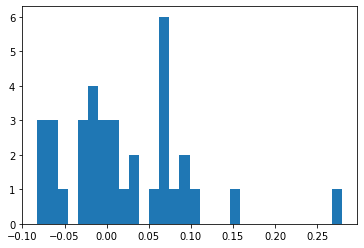

In [78]:
plt.hist((df_new - df_old).values.flatten(), bins=30);

In [26]:
df_row = meta[meta['fold'] == 0].iloc[0]
source_name = df_row['tomograph_model'] + str(df_row['tesla_value'])
sdices = {}
for n_val in range(3):
    sdices = {**sdices,
              **load(path_oracle_old / f'experiment_{0 * 3 + n_val}/test_metrics/sdice_score.json')}
res = np.mean(list(sdices.values()))

In [27]:
res

0.6537562411385104

In [33]:
[0 == 1]

[False]

In [34]:
1 in [0 == 1]

False

In [84]:
0 == 1 in [0 == 1]

False

In [86]:
0 == (1 in [0 == 1])

True

In [89]:
(0 == 1) in [0 == 1]

True

In [88]:
0 == 1 in [0 == 1]

False